# Click Throughs
Will they click our ad?

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use classification models to make click-through predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from importlib import reload


#import my personal modules created for this report
import wrangle as w
#import explore as e
#import model as m

## Acquire

* Data acquired from interviewquery github on December 12, 2022.
* It contained 600000 rows and 24 columns
* Each observation represents a visit to the website
* Each column represents a feature of those visits

In [2]:
#import train and test data sets from interviewquery github
unclean_click_through_data = w.acquire_click_through_data()

## Prepare
* Checked for nulls, there were none
* Changed the ```hour``` column to datetime
* Split data into train, validate, and test (65/20/15)

In [3]:
#prep data
click_through_data = w.prep_data(unclean_click_through_data)

In [4]:
#split data
train, validate, test = w.split_data(click_through_data)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**parcelid**| Definition| *int*|
| **bathroooms** | The number of bathrooms in the home. |*float*|
| **bedrooms** | The number of bedrooms in the home.|*int*|
|**sqft**| Square footage of the house| *int*|
|**year_built**| Year the house was built| *int*|
|**latitude**| | *float*|
|**longitude**| | *float*|
|**lotsizesquarefeet**| Square footage of the land where the property is located | *float*|
|**fireplace**| | *float*|
|**deck**| | *float*|
|**pool**| | *float*|
|**garage**| | *float*|
|**hottub**| | *float*|
|**county**| Name of the county where the house is located| *string*|
|**2017_age**| Age of the house in 2017 (when the data was collected| *int*|
|**Target variable**
|**logerror**| 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒) | *float* |

### A look at the data

In [5]:
#show the first few rows of the train data
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week,working_hours,nighttime
565087,5995015300359777433,0,2014-10-29 13:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,100084,79,13,Wednesday,True,False
8383,3893668501419868642,0,2014-10-23 06:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,576,2,35,-1,32,6,Thursday,False,True
367430,710950586232260345,0,2014-10-27 16:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,50,2104,0,559,-1,171,16,Monday,True,False
179207,2607601469275535009,1,2014-10-25 11:00:00,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,50,423,2,39,100148,32,11,Saturday,True,False
425761,10705641571307336952,0,2014-10-28 09:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,f0d41ff1,2347f47a,...,50,2665,0,34,-1,221,9,Tuesday,True,False


## Explore

### 1. What percentage of visits resulted in a click-through?

<AxesSubplot:xlabel='click', ylabel='count'>

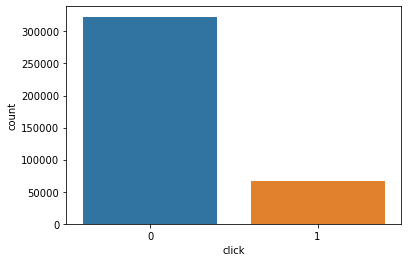

In [6]:
sns.countplot(data=train, x='click')

### 2. Does the hour of the day have an impact of click-throughs?

In [ ]:
# plotting defaults
plt.rc('figure', figsize=(20, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

<AxesSubplot:xlabel='hour_of_day'>

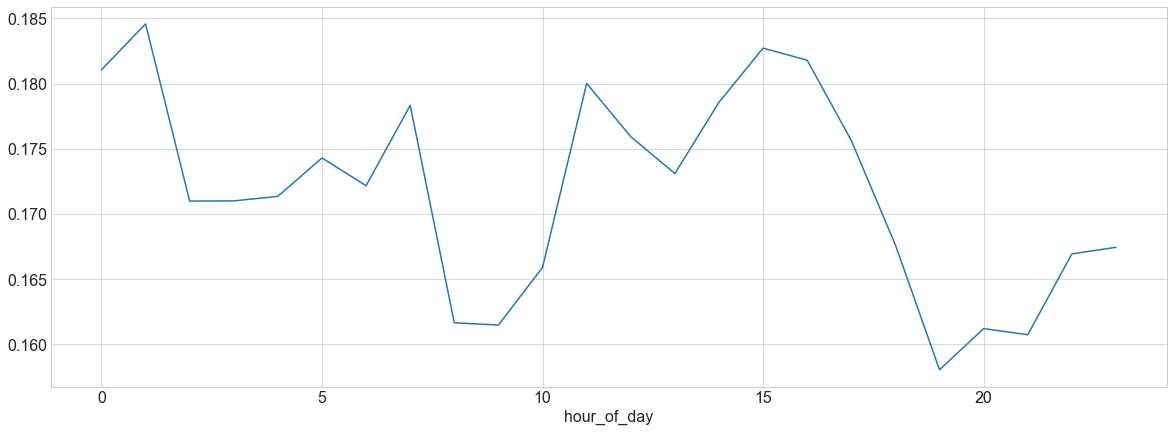

In [17]:
train.groupby('hour_of_day').click.mean().plot()

<AxesSubplot:xlabel='hour_of_day'>

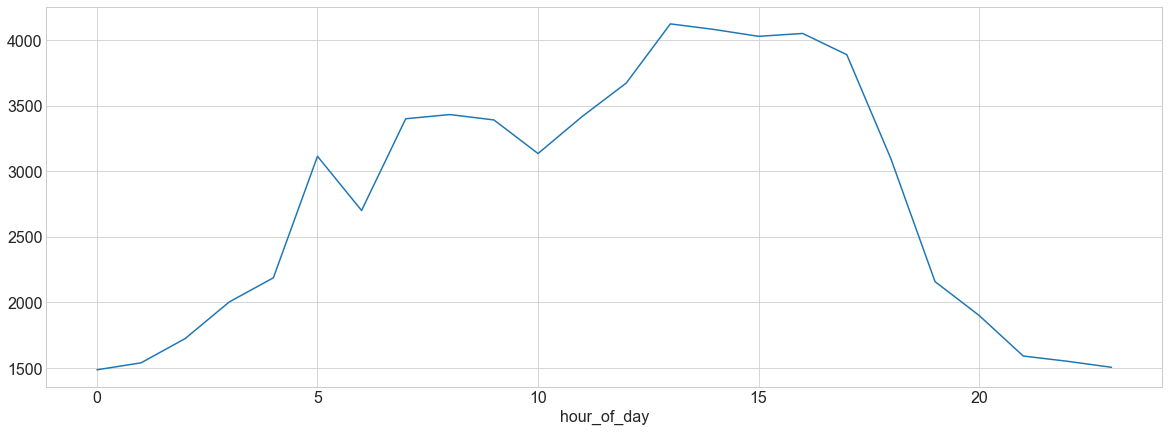

In [16]:
train.groupby('hour_of_day').click.sum().plot()

**It looks like there is a linear correlation between square feet and logerror.** 

***Also looks like the original model did a good job at predicting larger homes.***

**Set Hypothesis**

$H_0$ = There is no linear correlation between sqft and logerror 

$H_a$ = There is a linear correlation between sqft and logerror 

In [10]:
 #run spearman test to see if there is any linear correlation
corr, p = stats.spearmanr(train.sqft, train.logerror)

#print results
print(f"Correlation Coefficient: {corr:.2}\np-value: {p:.4}")

Correlation Coefficient: 0.079
p-value: 9.264e-48


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between square footage and logerror.** 

In [22]:
train_scale, validate_scale, test_scale =w.scale_zillow(train, validate, test, 'logerror')

In [87]:
train_scale

,parcelid,logerror,bathrooms,bedrooms,sqft,latitude,longitude,lotsizesquarefeet,fireplace,deck,pool,garage,hottub,county,2017_age,sqft_lotsize_feature,sqft_lotsize_cluster,special_features_cluster
46729,0.006,0.037,0.308,0.400,0.153,0.477,0.499,0.001,0.000,0.000,0.000,0.000,0.000,LA,0.080,1,2,1
47582,0.021,-0.104,0.077,0.300,0.040,0.262,0.831,0.001,0.000,0.000,1.000,1.000,1.000,Orange,0.478,0,0,2
32610,0.022,0.043,0.231,0.500,0.077,0.328,0.745,0.001,0.000,0.000,0.000,1.000,1.000,Orange,0.377,5,4,2
22180,0.007,-0.003,0.077,0.200,0.067,0.447,0.610,0.001,0.000,0.000,0.000,0.000,0.000,LA,0.754,5,0,1
28282,0.021,0.166,0.077,0.200,0.036,0.059,0.967,0.001,0.000,0.000,0.000,1.000,1.000,Orange,0.406,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30659,0.024,0.012,0.192,0.300,0.126,0.199,0.926,0.001,0.000,0.000,0.000,1.000,1.000,Orange,0.261,4,2,2
15594,0.014,-0.033,0.077,0.300,0.038,0.512,0.810,0.001,0.000,0.000,0.000,0.000,0.000,LA,0.449,0,0,1
28450,0.003,-0.074,0.077,0.400,0.059,0.869,0.686,0.008,0.000,0.000,0.000,0.000,0.000,LA,0.471,0,0,1
47657,0.023,0.089,0.115,0.300,0.039,0.207,0.808,0.001,0.000,0.000,0.000,1.000,1.000,Orange,0.442,0,0,2


## 3. ??????

## 4. ???????

**It looks like there is a linear correlation between ?????? and logerror**

**Set Hypothesis**

$H_0$ = There is no linear correlation between ?????? and logerror 

$H_a$ = There is a linear correlation between ?????? and logerror

In [13]:
#run spearmanr test and show results
#e.age_spearmanr(train)

**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between 2017_age and home value.** 

### Exploration Summary
* ```square_feet``` has the highest correlation coefficient so I will use it in my model.
* ```bed_bath_ratio```, ```2017_age```, and ```county``` all show a relationship with home value so I will also take them to my model.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**size_location_cluster**| |
|**bath_bed_ratio**| From our Spearman's test we saw that the correlation coefficient is 0.32 between ```bath_bed_ratio``` and ```home_value```|
|**2017_age**| From our Spearman's test we saw that the correlation coefficient is 0.27 between ```2017_age``` and ```home_value```|
|**county**| From our ANOVA test we see that there is a difference between the home values in each county|

### Features I'm not moving on with

| Feature | Reason 
|:--------|:-----------
|**parcelid**| id number that is not needed in the model
| **bathroooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
| **bedrooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
|**year_built**| Represented in the ```2017_age``` so it would be redundant.

### Prep for modeling
* I scaled the drivers using the minmax scaler
* Split the data into where ```home_value``` is the target variable

In [15]:
#prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train, validate, test, 'logerror', drivers)

### Baseline models
* Looked at both using mean and median as a baseline model.
* Mean baseline performed better on the in-sample and out-of sample data SO I went with mean.

In [18]:
import sklearn.metrics as metric

def baseline_models(y_train, y_validate):
    '''
    Takes in y_train and y_validate and returns a df of 
    baseline_mean and baseline_median and how they perform
    '''
    train_predictions = pd.DataFrame(y_train)
    validate_predictions = pd.DataFrame(y_validate)
    
    y_pred_mean = y_train.mean()
    train_predictions['y_pred_mean'] = y_pred_mean
    validate_predictions['y_pred_mean'] = y_pred_mean
    
    y_pred_median = y_train.median()
    train_predictions['y_pred_median'] = y_pred_median
    validate_predictions['y_pred_median'] = y_pred_median

    # create the metric_df as a blank dataframe
    metric_df = pd.DataFrame(data=[
    {
        'model': 'mean_baseline', 
        'RMSE_train': metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5,
        'RMSE_validate': metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5,
        'Difference': (( metric.mean_squared_error(
            y_train,
            train_predictions['y_pred_mean']) ** .5)-(metric.mean_squared_error(
            y_validate,
            validate_predictions['y_pred_mean']) ** .5))
    }])

    return metric_df.append(
            {
                'model': 'median_baseline', 
                'RMSE_train': metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5,
                'RMSE_validate': metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5,
                'Difference': (( metric.mean_squared_error(
                    y_train,
                    train_predictions['y_pred_median']) ** .5)-(metric.mean_squared_error(
                    y_validate,
                    validate_predictions['y_pred_median']) ** .5))
            }, ignore_index=True)

In [19]:
baseline_models(y_train, y_validate)

,model,RMSE_train,RMSE_validate,Difference
0,mean_baseline,0.174556,0.18238,-0.007824
1,median_baseline,0.174886,0.18275,-0.007864


### Model Comparison

In [ ]:
#run and compare models
#m.regression_models(X_train, y_train, X_validate, y_validate)

### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* It was interesting that OLS Regressor and Lasso Lars both performed better on the out-of-sample data.

### Best model: Random Forest Model 
* I chose the XXX (XXXXXXXXXX) because the difference in $RMSE$ between the train and validate was around  and they were both higher than the other models
* I will now run the that model on test data to gauge how it will perform on future data

In [ ]:
#m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion

### Summary
*


### Recommendations
* We should do more research .
* .

### Next Steps
* In the next iteration:
    * 